In [1]:
from pathlib import Path

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import polars as pl

from src.constant import LABELS
from src.preprocess import load_eeg, process_label, calc_weight
from src.visualization import format_time, plot_eeg

plt.style.use("tableau-colorblind10")

In [2]:
data_dir = Path("../../../input/hms-harmful-brain-activity-classification")
list(data_dir.glob("*"))
metadata = pl.read_csv(data_dir / "train.csv")
metadata = process_label(metadata)
metadata = metadata.group_by("eeg_id").agg(
    *[
        pl.col(f"{label}_prob_per_eeg").first().alias(f"{label}_prob")
        for label in LABELS
    ],
    pl.col("weight_per_eeg").first().alias("weight"),
)
metadata.head()

eeg_id,seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,weight
i64,f64,f64,f64,f64,f64,f64,f64
2607581913,0.0,0.0,0.0,0.0,1.0,0.0,0.107143
3169557321,0.288136,0.0,0.0,0.29661,0.0,0.415254,0.468254
3372597624,0.0,0.0,0.0,0.0,0.0,1.0,0.035714
1903868611,0.0,0.0,0.0,0.0,1.0,0.0,0.107143
911408786,0.0,0.0,0.0,1.0,0.0,0.0,0.107143


seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,weight
f64,f64,f64,f64,f64,f64,f64
0.329365,0.107882,0.062975,0.083806,0.164998,0.250975,0.12212


seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,weight
f64,f64,f64,f64,f64,f64,f64
0.041959,0.18154,0.12532,0.072379,0.090424,0.488378,0.513


seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,weight
f64,f64,f64,f64,f64,f64,f64
0.036192,0.1456,0.136346,0.03226,0.073729,0.575874,0.04915


High Quality: 5525
Low Quality: 6689
Very Low Quality: 4875


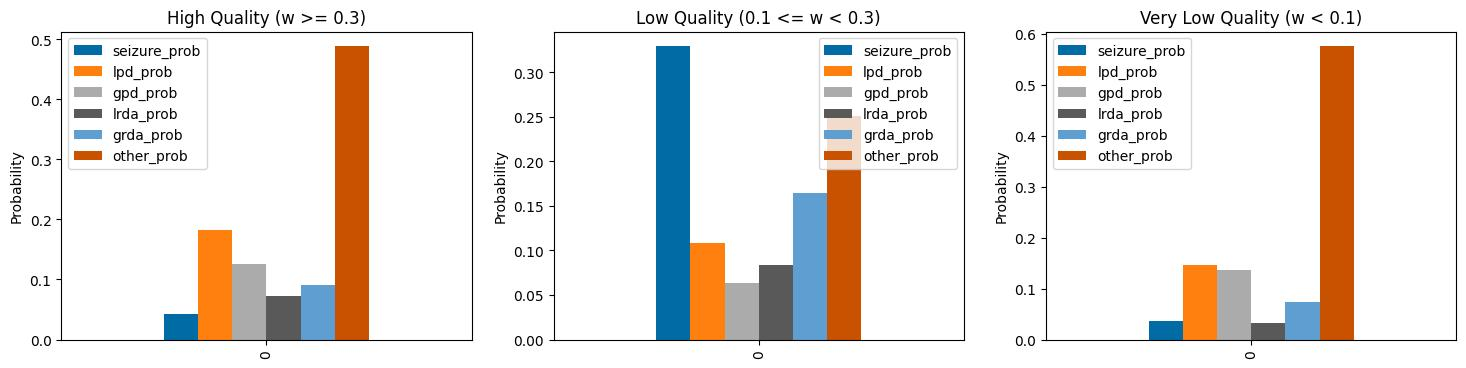

In [3]:
high_quality = metadata.filter(pl.col("weight").ge(0.3))
low_quality = metadata.filter(pl.col("weight").lt(0.3).and_(pl.col("weight").ge(0.1)))
very_low_quality = metadata.filter(pl.col("weight").lt(0.1))

display(low_quality.drop("eeg_id").mean())
display(high_quality.drop("eeg_id").mean())
display(very_low_quality.drop("eeg_id").mean())
print(f"High Quality: {high_quality.shape[0]}")
print(f"Low Quality: {low_quality.shape[0]}")
print(f"Very Low Quality: {very_low_quality.shape[0]}")

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
high_quality.drop("eeg_id", "weight").mean().to_pandas().plot.bar(ax=ax1)
low_quality.drop("eeg_id", "weight").mean().to_pandas().plot.bar(ax=ax2)
very_low_quality.drop("eeg_id", "weight").mean().to_pandas().plot.bar(ax=ax3)

ax1.set(title="High Quality (w >= 0.3)", ylabel="Probability")
ax2.set(title="Low Quality (0.1 <= w < 0.3)", ylabel="Probability")
ax3.set(title="Very Low Quality (w < 0.1)", ylabel="Probability")
plt.show()